In [2]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os 

In [3]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator

In [4]:
img_width = 224
img_height = 224
batch_size = 64

In [5]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    #data_format="channels_last",
    validation_split=0.2,
)

train_generator = datagen.flow_from_directory(
    "PetImages/",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    #color_mode="grayscale",
    class_mode="sparse",
    shuffle=True,
    subset="training",
    seed=123,
)

val_data_gen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,
)

validation_generator = datagen.flow_from_directory(
    "PetImages/",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    #color_mode="grayscale",
    class_mode="sparse",
    shuffle=True,
    subset="validation",
    seed=123,
)

Found 19957 images belonging to 2 classes.
Found 4989 images belonging to 2 classes.


In [25]:
print(train_generator.image_shape)

idx_to_classes ={val:key for key,val in dict(train_generator.class_indices).items()}
idx_to_classes

(224, 224, 3)


{0: 'Cat', 1: 'Dog'}

In [7]:
#steps
train_steps = len(train_generator)
validation_steps = len(validation_generator)

In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224,224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2)(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    
    layer.trainable = False

model.compile(loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=True)], optimizer='adam',metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [10]:
history = model.fit(
            train_generator,
            epochs=1,
            steps_per_epoch=train_steps,
            validation_data=validation_generator,
            validation_steps=validation_steps,
)

312/312 [==============================] - 832s 3s/step - loss: 0.0919 - accuracy: 0.9654 - val_loss: 0.0893 - val_accuracy: 0.9657


Model Metrics

In [11]:
train_loss = history.history["loss"]
train_accuracy = history.history["accuracy"]
test_loss = history.history["val_loss"]
test_accuracy = history.history["val_accuracy"]

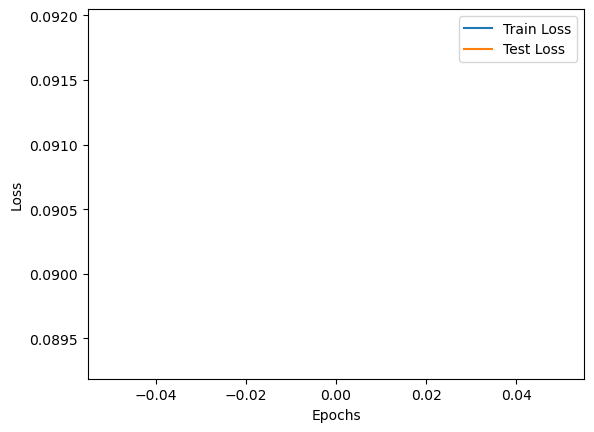

In [13]:
plt.plot(range(1), train_loss, label = "Train Loss")
plt.plot(range(1), test_loss, label = "Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

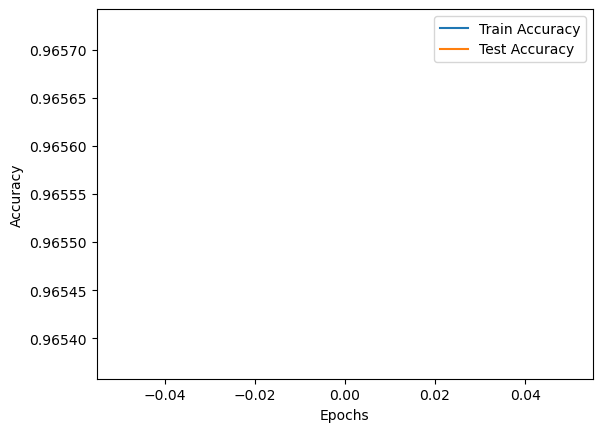

In [14]:
plt.plot(range(1), train_accuracy, label = "Train Accuracy")
plt.plot(range(1), test_accuracy, label = "Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [15]:
pred_list = [f"test_imgs/{i}" for i in os.listdir("test_imgs/")]

Model Prediction

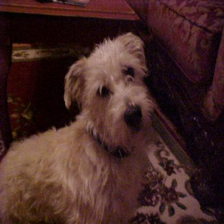

1
Model Prediction:  Dog


In [51]:
pred_list = [f"test_imgs/{i}" for i in os.listdir("test_imgs/")]


from PIL import Image

img = Image.open(pred_list[1])
img = img.resize((224, 224))
display(img)

img_arr = np.array(img)
img_arr = img_arr[np.newaxis, :]
img_arr = img_arr.astype("float")
img_arr = val_data_gen.standardize(img_arr)
probability = model(img_arr)
pred = np.argmax(probability)
print(pred)
print("Model Prediction: ",idx_to_classes[pred])


############################################################################

In [49]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def preprocess_image(image_path):
    # Load the image
    image = load_img(image_path, target_size=(224, 224))

    # Convert the image to an array
    image_array = img_to_array(image)

    # Reshape the array to have a single batch dimension
    image_array = np.expand_dims(image_array, axis=0)

    # Normalize the pixel values by dividing by 255
    image_array = image_array / 255.0

    return image_array



In [50]:
# Example usage
image_path = 'test_imgs/17.jpg'
preprocessed_image = preprocess_image(image_path)

output = model.predict(preprocessed_image)
predicted_values = output[0]
print("Predicted values:", predicted_values)

class_index = np.argmax(predicted_values)  
print("Predicted class:", class_index)

print("Model Prediction: ",idx_to_classes[class_index])

1/1 [==============================] - 0s 51ms/step
Predicted values: [ 3.5684514 -4.0668364]
Predicted class: 0
Model Prediction:  Cat
